In [1]:
import os
import nibabel as nib
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from sklearn import preprocessing
from tqdm import tqdm
import scipy.ndimage

**Checking images and labels**



In [2]:
# Set the path to the directory containing the medical images
image_dir = 'C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/images'
# Set the path to the directory containing the medical labels
label_dir = 'C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/labels'
# Set the path to the directory for saving the resized images
resized_image_dir = 'C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/resized_images'
# Set the path to the directory for saving the resized labels
resized_label_dir = 'C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/resized_labels'

class_num = 8

In [3]:
test_image = nib.load('C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/images/mr_train_1001_image.nii')
test_label = nib.load('C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/labels/mr_train_1001_label.nii')

print("Image shape: ", test_image.shape)
print("Label shape: ", test_label.shape)

Image shape:  (512, 512, 160)
Label shape:  (512, 512, 160)


In [5]:
image_data = test_image.affine
print(image_data)
image_header = test_image.header['pixdim']
print(image_header)
print(test_image)

[[  -0.78125       0.            0.          206.08695984]
 [   0.            0.           -1.60000002  155.02609253]
 [   0.            0.78125       0.         -199.21875   ]
 [   0.            0.            0.            1.        ]]
[-1.          0.78125     0.78125     1.6         0.28585002  0.
  0.          0.        ]

<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 160)
affine:
[[  -0.78125       0.            0.          206.08695984]
 [   0.            0.           -1.60000002  155.02609253]
 [   0.            0.78125       0.         -199.21875   ]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 16
dim             : [  3 512 512 160   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
data

In [6]:
label_data = test_label.affine
print(label_data)
label_header = test_label.header['pixdim']
print(label_header)
print(test_label)

[[  -0.78125       0.            0.          206.08695984]
 [   0.            0.           -1.60000002  155.02609253]
 [   0.            0.78125       0.         -199.21875   ]
 [   0.            0.            0.            1.        ]]
[-1.       0.78125  0.78125  1.6      1.       0.       0.       0.     ]

<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 160)
affine:
[[  -0.78125       0.            0.          206.08695984]
 [   0.            0.           -1.60000002  155.02609253]
 [   0.            0.78125       0.         -199.21875   ]
 [   0.            0.            0.            1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 16
dim             : [  3 512 512 160   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uin

7 segmentacijskih podstruktura srca u training setu:

1. the left ventricle blood cavity (label value 500)
2. the right ventricle blood cavity (label value 600)
3. the left atrium blood cavity (label value 420)
4. the right atrium blood cavity (label value 550)
5. the myocardium of the left ventricle (label value 205)
6. the ascending aorta (label value 820)
7. the pulmonary artery (label value 850) 

The ascending aorta is defined as the aortic trunk from the aortic valve to the superior level of the atria. The pulmory artery defined as the beginning trunk between the pulmonary valve and the bifurcation point. In both cases, the mean length of this trunk is about 41.9 mm as measured in 25 healthy subjects.

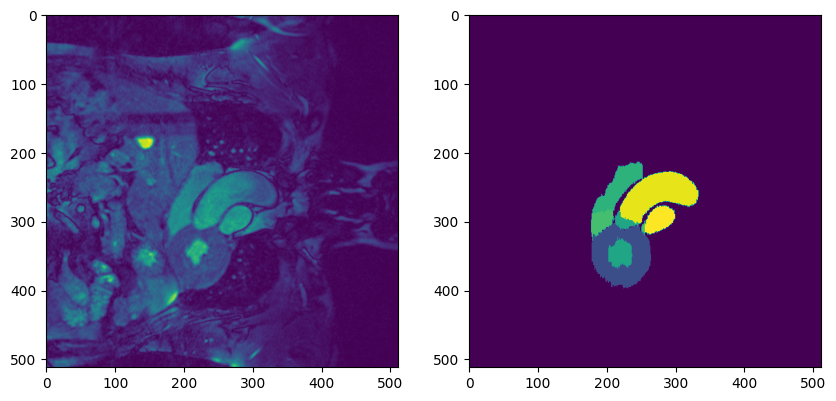

In [7]:
img_data = test_image.get_fdata()
lb_data = test_label.get_fdata()

f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img_data[:,:,60])
ax[1].imshow(lb_data[:,:,60])

**Label i shape prema klasi**

In [8]:
cls, cnt = np.unique(lb_data, return_counts=True)
print('Class values: ',cls)
print('Number of Classes: ',cnt)

Class values:  [  0. 205. 420. 500. 550. 600. 820. 850.]
Number of Classes:  [41292779   177779   100824    54017    95486    76322    97177    48656]


In [9]:
mri1_mask = lb_data == 500
mri2_mask = lb_data == 600
mri3_mask = lb_data == 420
mri4_mask = lb_data == 550
mri5_mask = lb_data == 205
mri6_mask = lb_data == 820
mri7_mask = lb_data == 850

mri1_label = lb_data * mri1_mask
mri2_label = lb_data * mri2_mask
mri3_label = lb_data * mri3_mask
mri4_label = lb_data * mri4_mask
mri5_label = lb_data * mri5_mask
mri6_label = lb_data * mri6_mask
mri7_label = lb_data * mri7_mask
mri_labels = [mri1_label, mri2_label, mri3_label, mri4_label, mri5_label, mri6_label, mri7_label]



In [10]:
for i in range(len(mri_labels)):
    print('class {} shape: {}'.format(i, mri_labels[i].shape))

class 0 shape: (512, 512, 160)
class 1 shape: (512, 512, 160)
class 2 shape: (512, 512, 160)
class 3 shape: (512, 512, 160)
class 4 shape: (512, 512, 160)
class 5 shape: (512, 512, 160)
class 6 shape: (512, 512, 160)


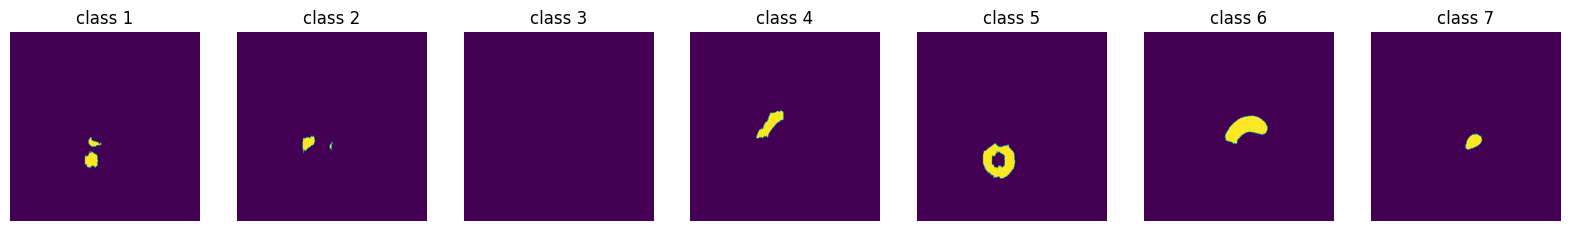

In [11]:
f, ax = plt.subplots(1,7,figsize=(20,5))

for i in range(len(mri_labels)):
    ax[i].imshow(mri_labels[i][:,:,60])
    ax[i].axis('off')
    ax[i].set_title('class '+str(i+1))

**Proces resizing slika**

In [4]:
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.nii')]
label_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.nii')]
image_shapes = []
label_shapes = []

for file in image_files:
    image = nib.load(file)
    image_shape = image.shape
    image_shapes.append(image_shape)

for i, shape in enumerate(image_shapes):
    print(f"Image {i+1} shape: {shape}")

Image 1 shape: (512, 512, 160)
Image 2 shape: (512, 512, 128)
Image 3 shape: (288, 288, 160)
Image 4 shape: (288, 288, 120)
Image 5 shape: (288, 288, 130)
Image 6 shape: (256, 256, 160)
Image 7 shape: (288, 288, 180)
Image 8 shape: (288, 288, 130)
Image 9 shape: (512, 512, 120)
Image 10 shape: (288, 288, 160)
Image 11 shape: (288, 288, 160)
Image 12 shape: (512, 512, 128)
Image 13 shape: (512, 512, 112)
Image 14 shape: (512, 512, 160)
Image 15 shape: (340, 340, 200)
Image 16 shape: (288, 288, 130)
Image 17 shape: (288, 288, 140)
Image 18 shape: (288, 288, 150)
Image 19 shape: (288, 288, 135)
Image 20 shape: (288, 288, 135)


In [13]:
for i, file in enumerate(label_files):
    label = nib.load(file) 
    lb_data = label.get_fdata()
    cls, cnt = np.unique(lb_data, return_counts=True)
    print(f"Label {i+1}:")
    print(f"Class values: {cls}")

Label 1:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 2:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 3:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 4:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 5:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 6:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 7:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 8:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 9:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 10:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 11:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 12:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 13:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 14:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 15:
Class values: [  0. 205. 420. 500. 550. 600. 820. 850.]
Label 16:
Class val

Labela 10. MRI slike ima dodatnu, devetu klasu stoga se morala korigirati.  

In [ ]:
lb_data = nib.load(label_files[9]).get_fdata()
lb_data[lb_data == 421] = 420
nib.save(nib.Nifti1Image(lb_data, nib.load(label_files[9]).affine), label_files[9])

In [26]:
lb_10 = nib.load(label_files[9]).get_fdata()
cls, cnt = np.unique(lb_10,return_counts=True)
print('Class values: ',cls)

Class values:  [  0. 205. 420. 500. 550. 600. 820. 850.]


In [5]:
label_encoder = preprocessing.LabelEncoder()

**Postupak resizing slika**

In [6]:
def pad3d(array):
    x0 = array.shape[0]
    x2 = array.shape[2]    
    if x0 > x2:
        height = x0
        depth = x2
    elif x2 > x0:
        height = x2
        depth = x0
    
    if (height - depth) % 2 :
        pad_front = int((height + 1 - depth) / 2)
        pad_back = int((height - 1 - depth) / 2)
    else:
        pad_front = pad_back = int((height - depth) / 2)
    
    if x0 > x2:    
        npad = ((0,0),(0,0),(pad_front,pad_back))
    elif x2 > x0:
        npad = ((pad_front,pad_back),(0,0),(0,0))
        
    array_padding = np.pad(array, npad, 'constant', constant_values=(0))
    array_padding[array_padding<0] = 0
    
    return array_padding

In [7]:
def image_preprocess(image, new_size, mask=False):
    assert np.sum(image.shape==image.shape[0])!=3    
    
    ratio = new_size / image.shape[0]
    
    image = scipy.ndimage.zoom(image, zoom=ratio, order=0)

    if mask:
        channel = 7 + 1 
        image = image.reshape(-1)
        image = label_encoder.fit_transform(image)
        image = to_categorical(image, class_num)
    else:
        channel = 1
    image = image.reshape((new_size,)*3 + (channel,))
    return image

In [8]:
def axis_transform(image):
    idx = 0
    if np.sum(image[2,:,int(image.shape[-1]/2)]) == 0:
        image = image.T
        image = np.flip(image,axis=0)
        idx += 1
    return image, idx    

In [31]:
pad_images = np.zeros((len(image_files),256,256,256,1))
transform_idx = list()
for i in tqdm(range(len(image_files))):
    image = nib.load(image_files[i]).get_fdata()
    image, idx = axis_transform(image)
    image = pad3d(image)
    image = image_preprocess(image, new_size=256)
    pad_images[i,:,:,:,:] = image
    transform_idx.append(idx)


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


In [32]:
pad_labels = np.zeros((len(label_files),256,256,256,8))
for i in tqdm(range(len(label_files))):
    image = nib.load(label_files[i]).get_fdata()
    if transform_idx[i]:
        image, _ = axis_transform(image)
    image = pad3d(image)
    image = image_preprocess(image, new_size=256, mask=True)
    pad_labels[i,:,:,:,:] = image


100%|██████████| 20/20 [01:35<00:00,  4.76s/it]


(512, 512, 160)


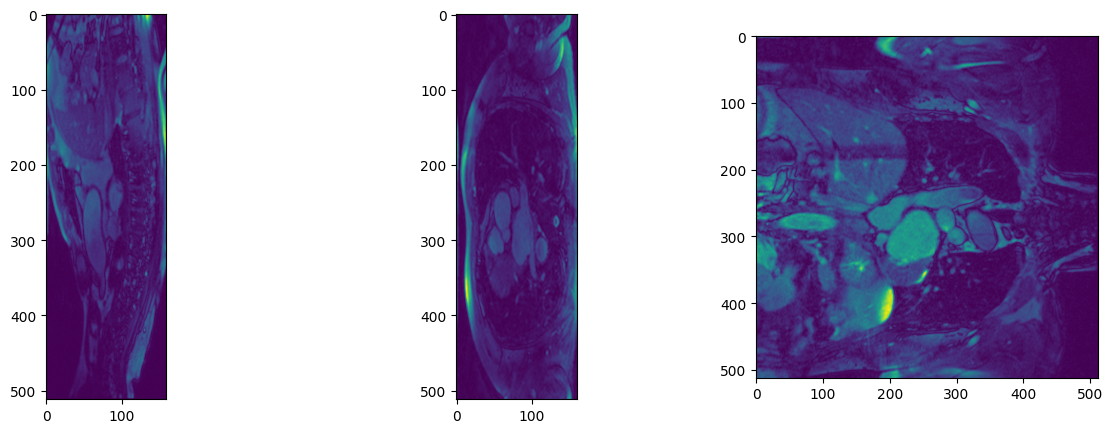

In [33]:
f, ax = plt.subplots(1,3, figsize=(15,5))
image_files = [nib.load(f) for f in image_files]
image = image_files[0].get_fdata()
print(image.shape)
ax[0].imshow(image[int(image.shape[0]/2),:,:])
ax[1].imshow(image[:,int(image.shape[1]/2),:])
ax[2].imshow(image[:,:,int(image.shape[2]/2)])


(288, 288, 160)
(288, 160)
(288, 160)
(288, 288)


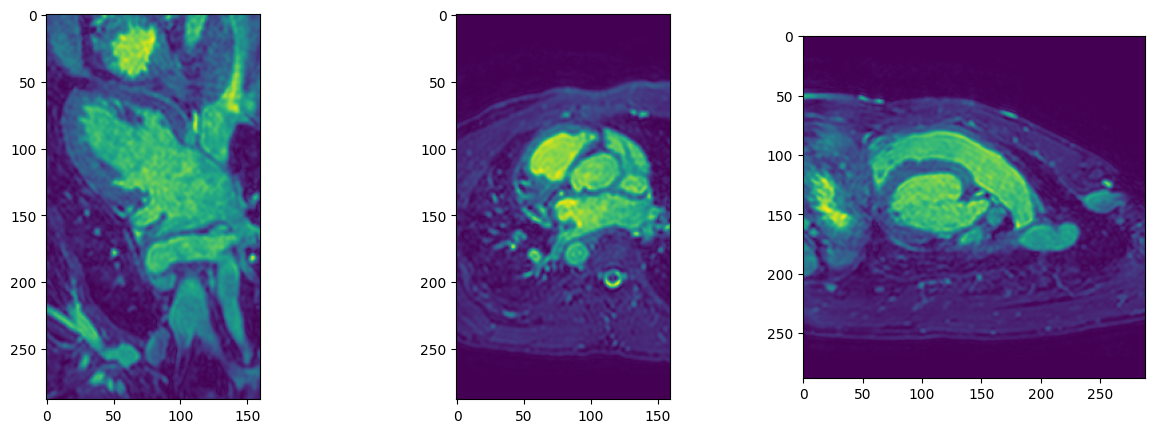

In [34]:
f, ax = plt.subplots(1,3, figsize=(15,5))
image = image_files[9].get_fdata()
print(image.shape)
print(image[int(image.shape[0]/2),:,:].shape)
print(image[:,int(image.shape[1]/2),:].shape)
print(image[:,:,int(image.shape[2]/2)].shape)
ax[0].imshow(image[int(image.shape[0]/2),:,:])
ax[1].imshow(image[:,int(image.shape[1]/2),:])
ax[2].imshow(image[:,:,int(image.shape[2]/2)])

In [35]:
image = image.T

(160, 288, 288)
(288, 288)
(160, 288)
(160, 288)


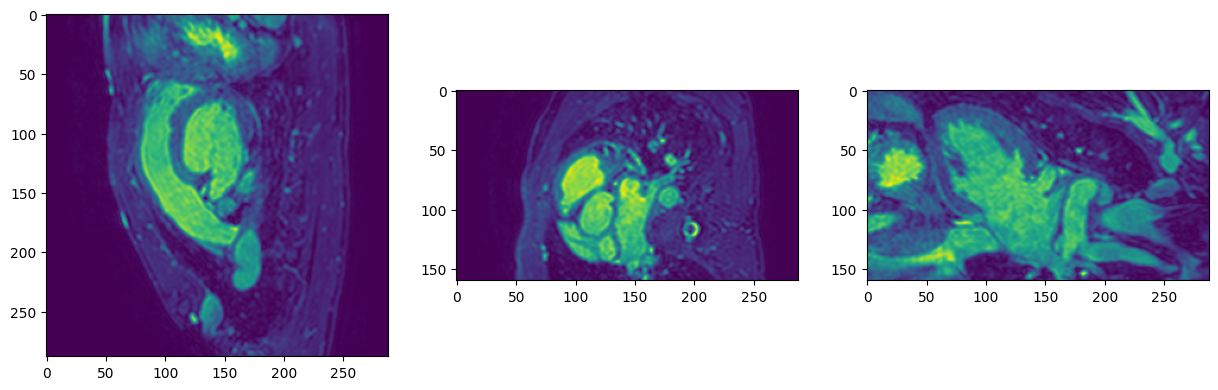

In [36]:
f, ax = plt.subplots(1,3, figsize=(15,5))
print(image.shape)
print(image[int(image.shape[0]/2),:,:].shape)
print(image[:,int(image.shape[1]/2),:].shape)
print(image[:,:,int(image.shape[2]/2)].shape)
ax[0].imshow(image[int(image.shape[0]/2),:,:])
ax[1].imshow(image[:,int(image.shape[1]/2),:])
ax[2].imshow(image[:,:,int(image.shape[2]/2)])

In [37]:
image = np.flip(image,axis=0)

(160, 288, 288)
(288, 288)
(160, 288)
(160, 288)


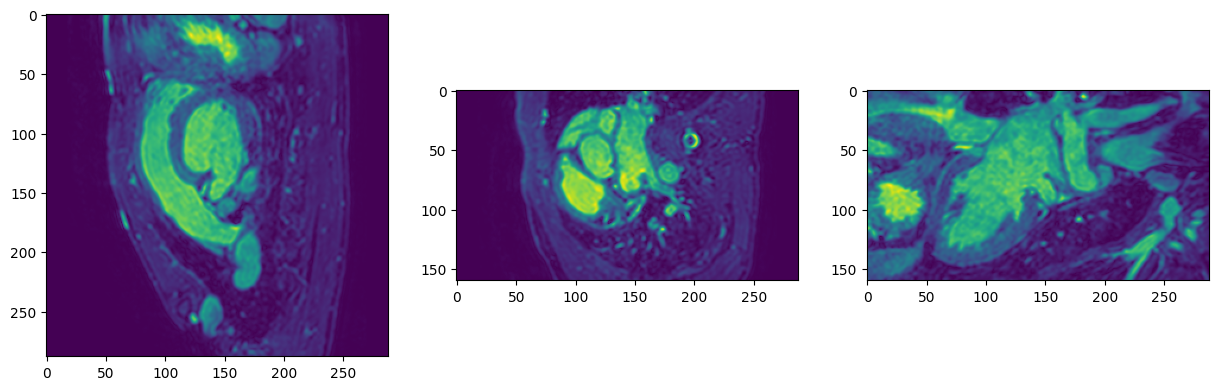

In [38]:
f, ax = plt.subplots(1,3, figsize=(15,5))
print(image.shape)
print(image[int(image.shape[0]/2),:,:].shape)
print(image[:,int(image.shape[1]/2),:].shape)
print(image[:,:,int(image.shape[2]/2)].shape)
ax[0].imshow(image[int(image.shape[0]/2),:,:])
ax[1].imshow(image[:,int(image.shape[1]/2),:])
ax[2].imshow(image[:,:,int(image.shape[2]/2)])

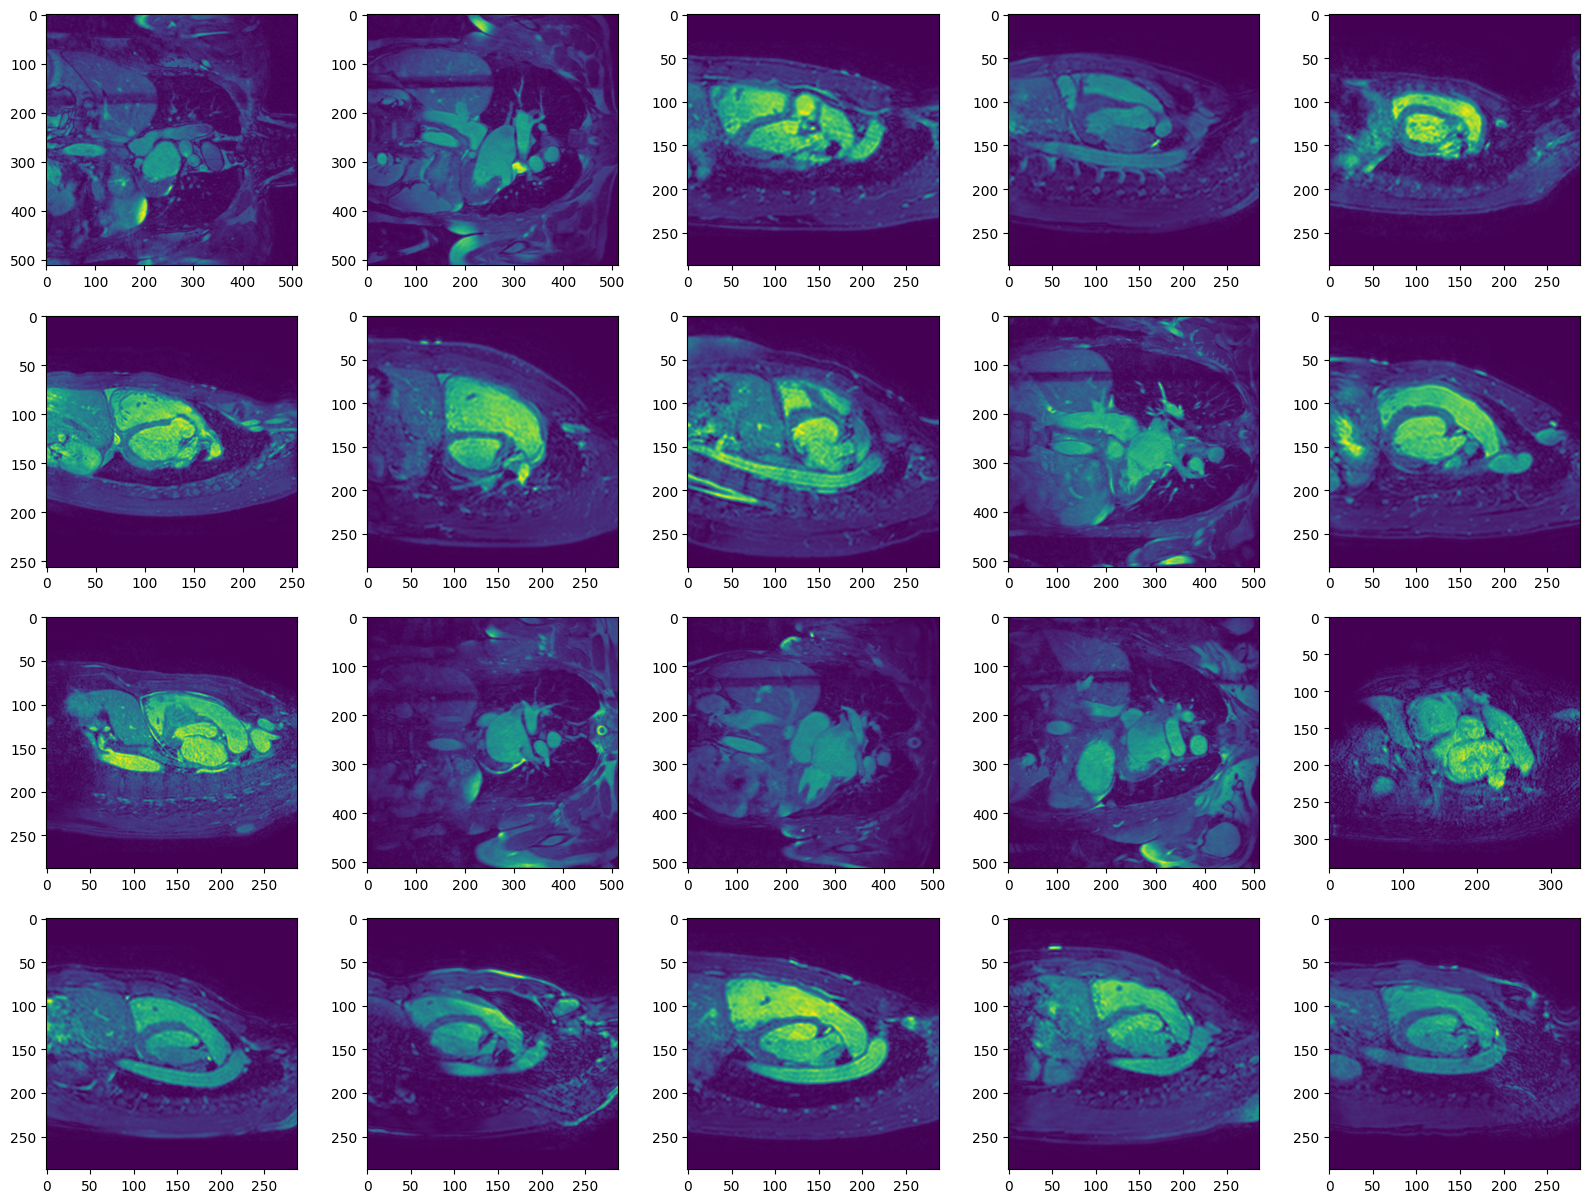

In [39]:
f, ax = plt.subplots(4,5, figsize=(20,15))
for i in range(4*5):
    ax[i//5,i%5].imshow(image_files[i].get_fdata()[:,:,int(image_files[i].shape[2]/2)])

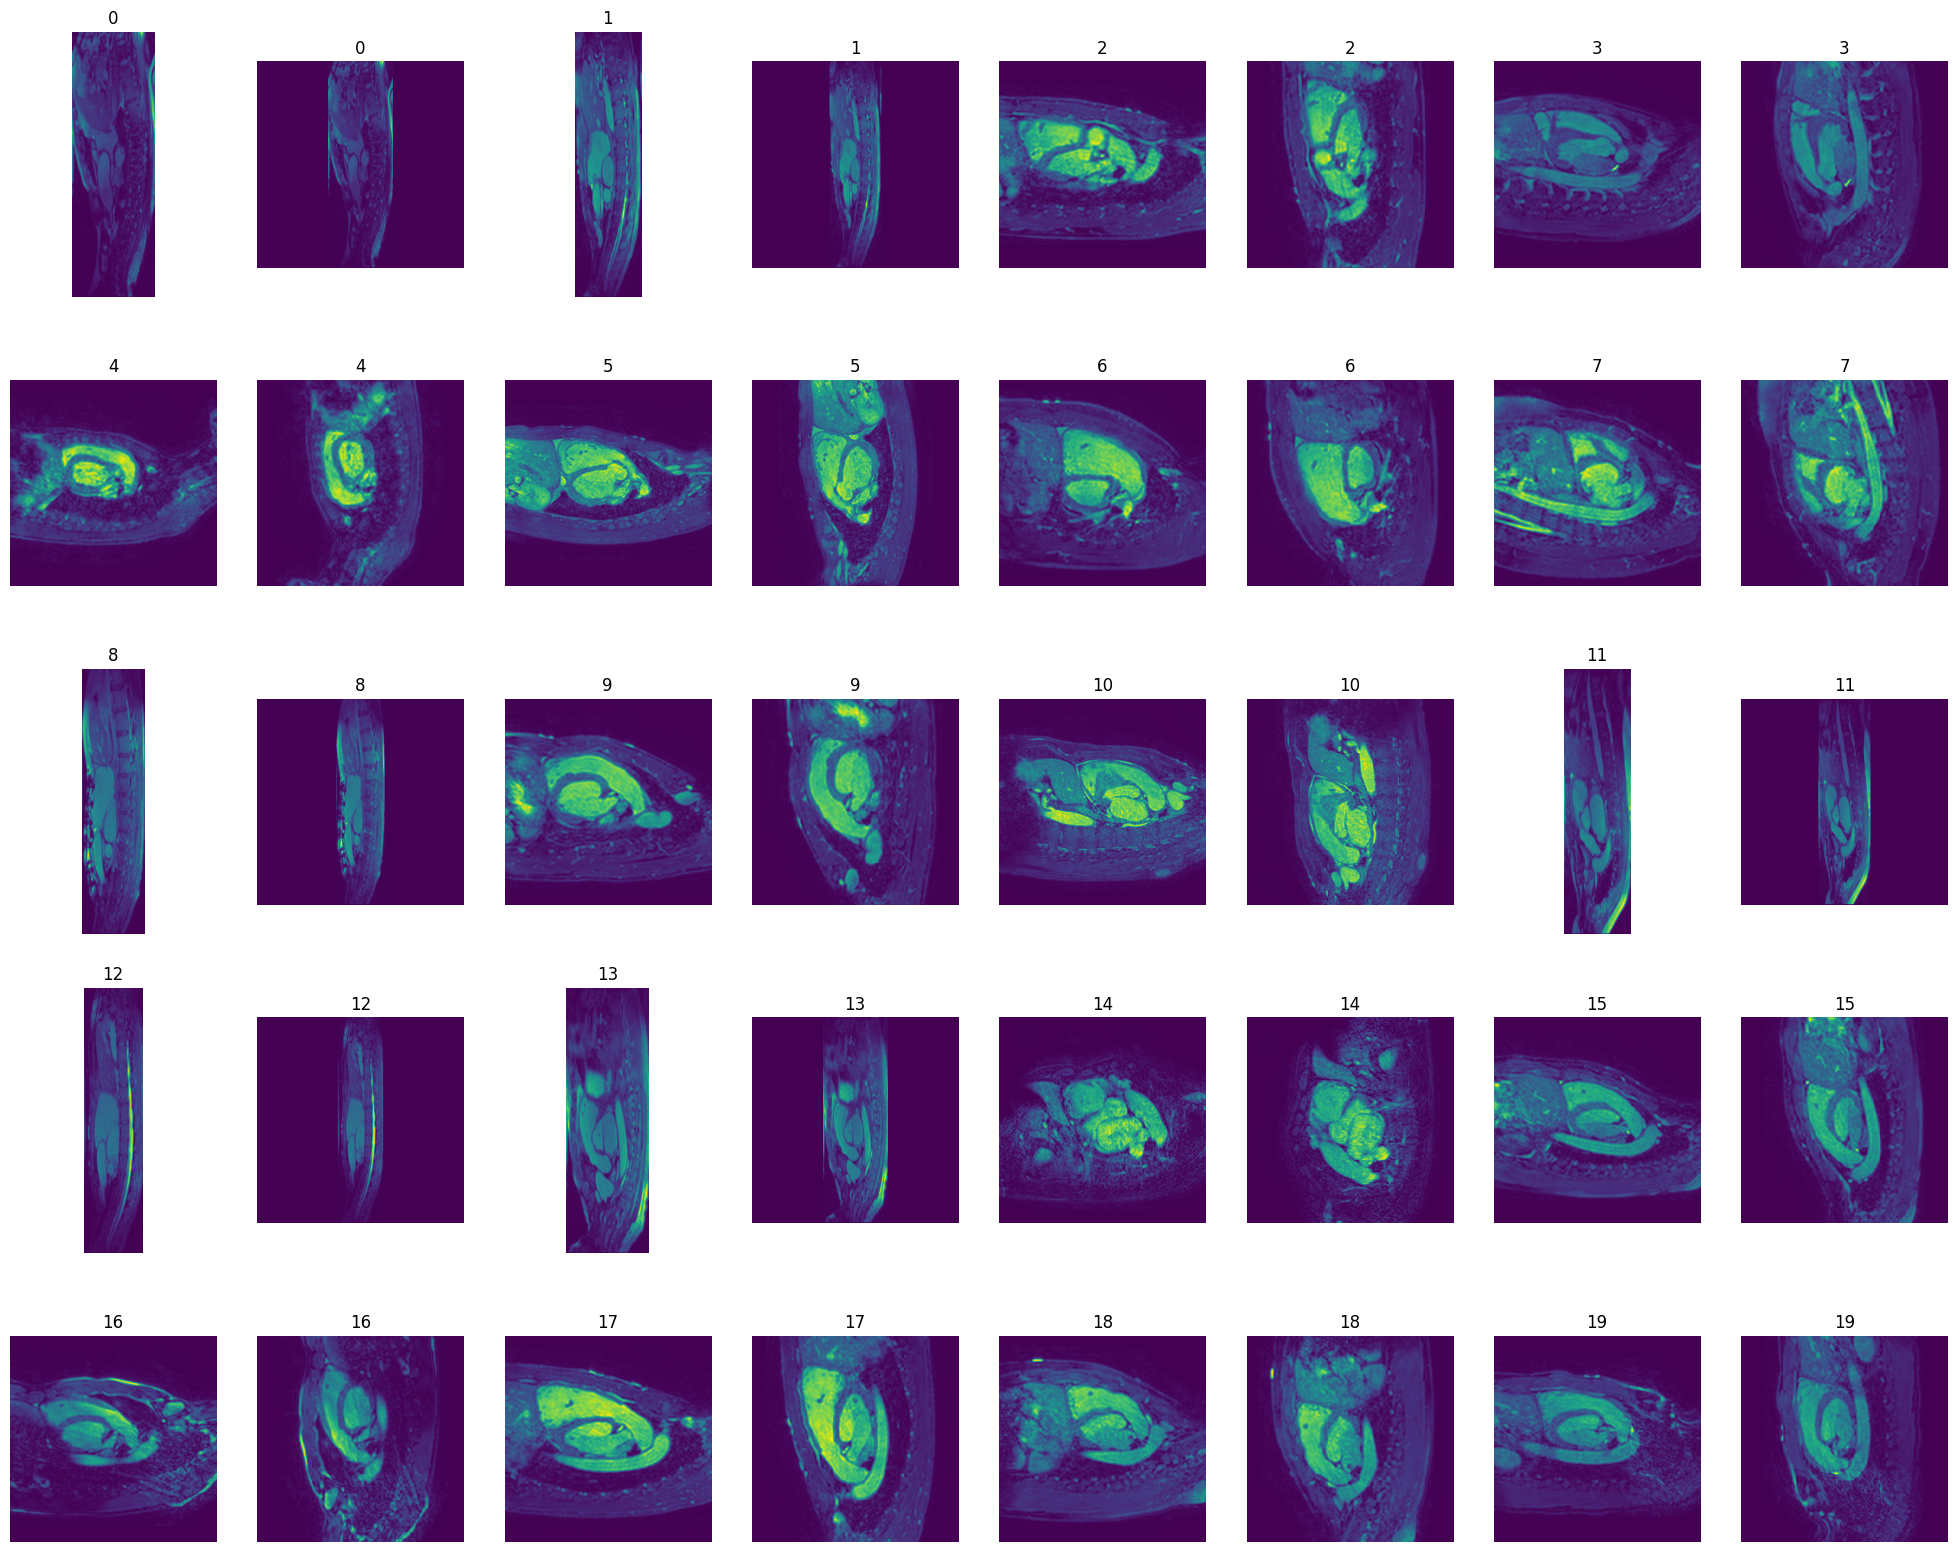

In [40]:
f, ax = plt.subplots(5,8, figsize=(25,20))
img_idx = 0
pad_idx = 0
for i in range(5*8):
    if (i%8)%2==0:
        if transform_idx[img_idx]:
            ax[i//8,i%8].imshow(image_files[img_idx].get_fdata()[:,:,int(image_files[img_idx].shape[2]/2)])
        else:
            ax[i//8,i%8].imshow(image_files[img_idx].get_fdata()[int(image_files[img_idx].shape[0]/2),:,:])
        ax[i//8,i%8].axis('off')
        ax[i//8,i%8].set_title(img_idx)
        img_idx+=1
    else:
        img = pad_images[pad_idx].reshape(pad_images[pad_idx].shape[:-1])
        ax[i//8,i%8].imshow(img[int(img.shape[0]/2),:,:])
        ax[i//8,i%8].axis('off')
        ax[i//8,i%8].set_title(pad_idx)
        pad_idx+=1

**provjera poklapanja slika i labela**

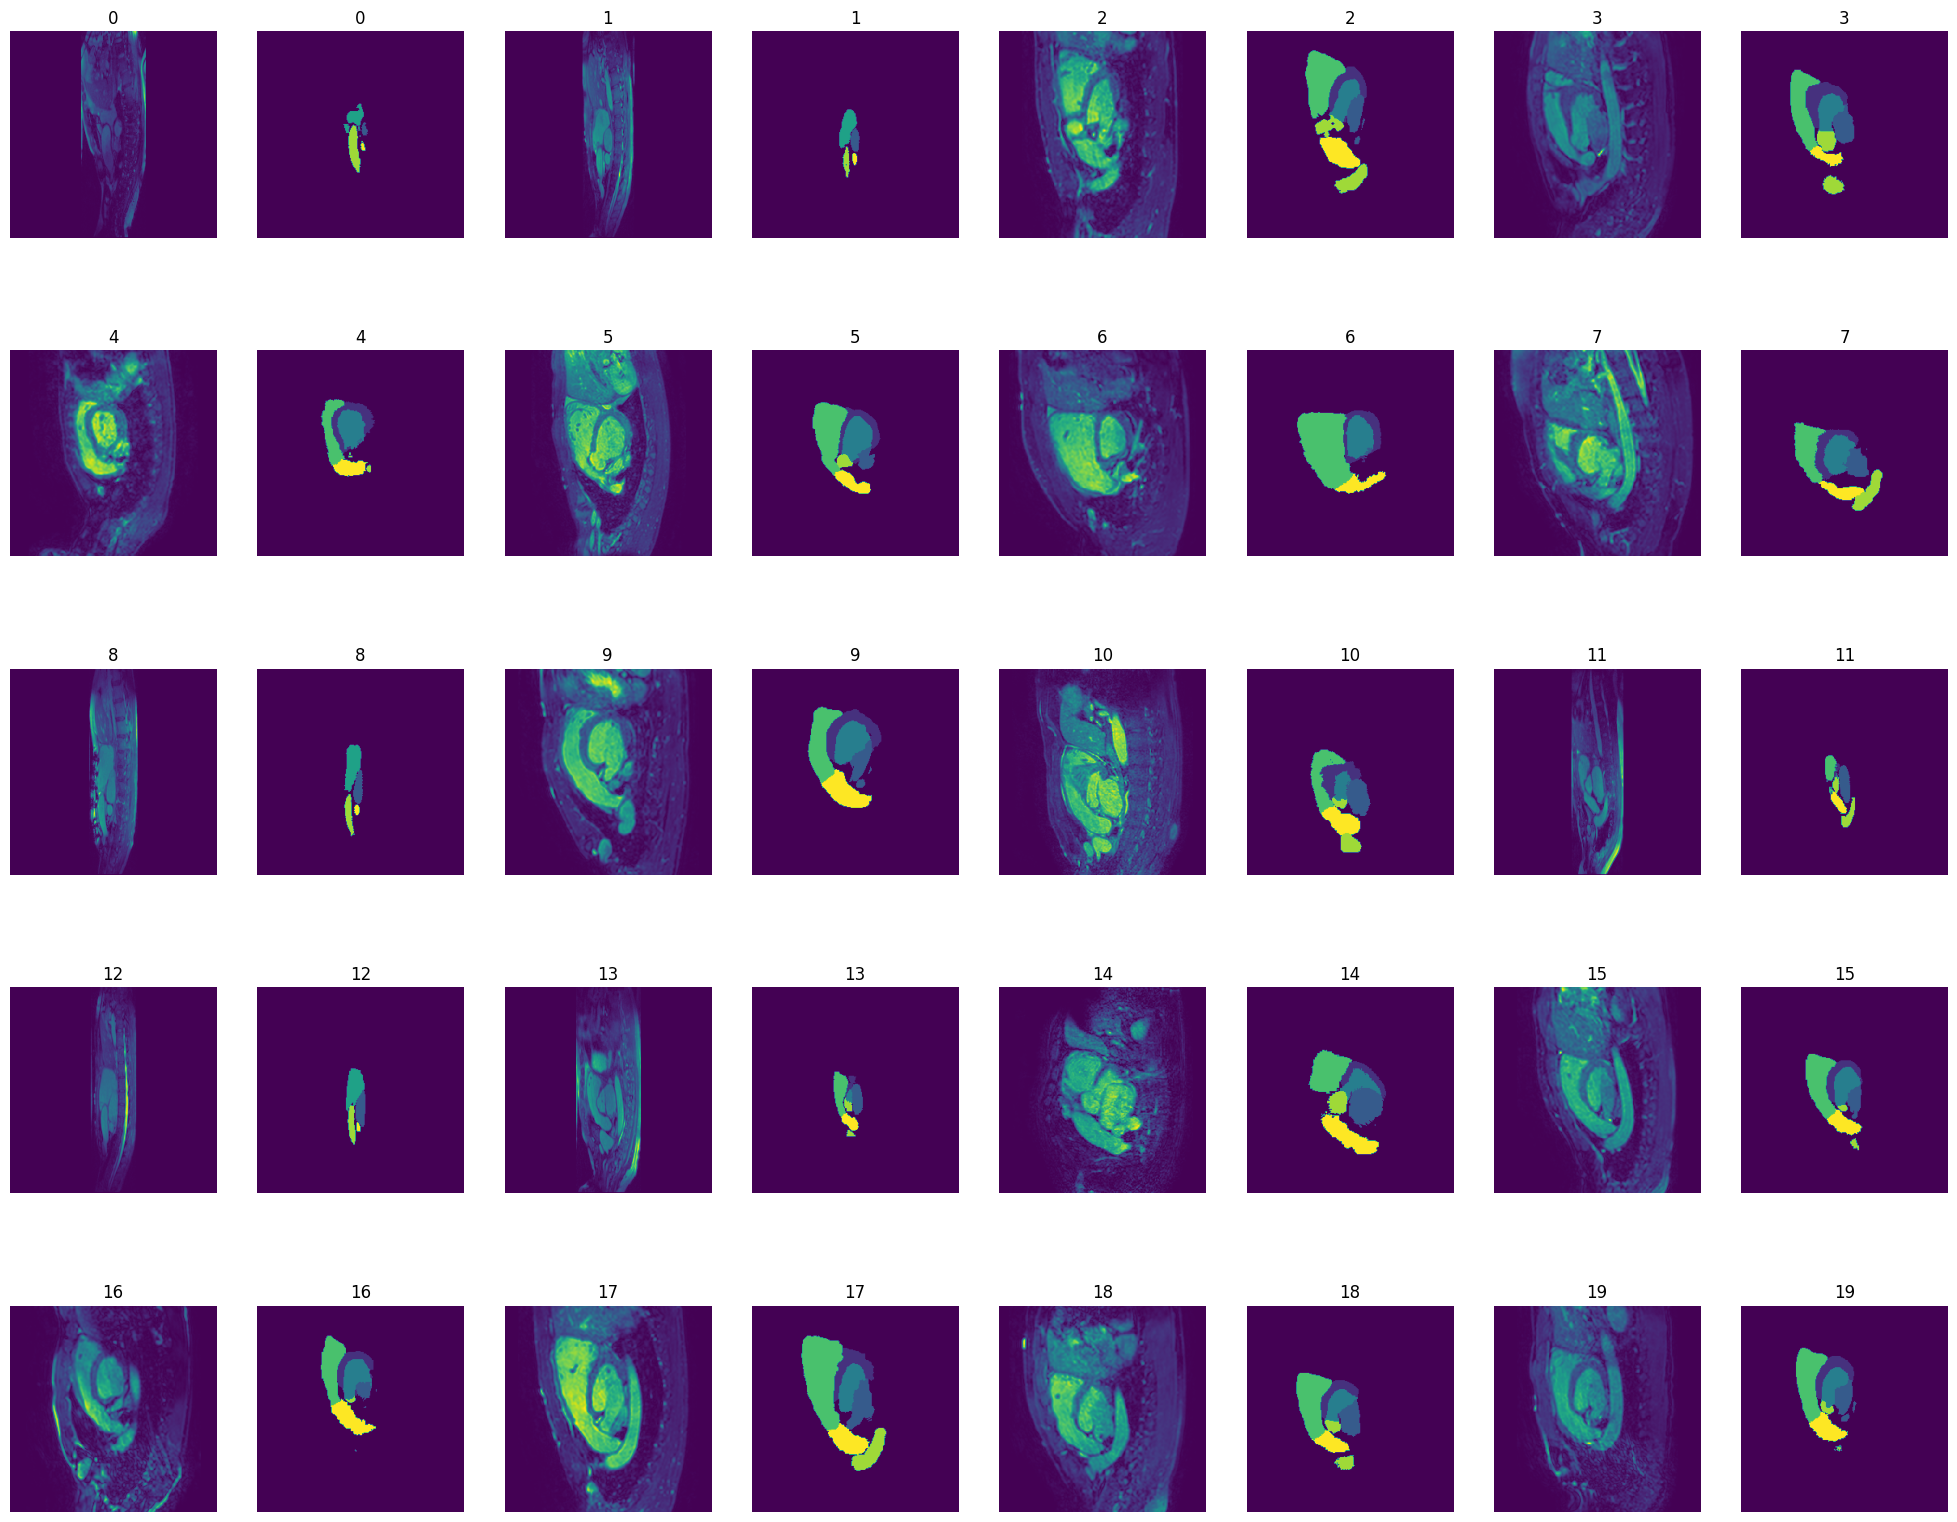

In [41]:
f, ax = plt.subplots(5,8, figsize=(25,20))
img_idx = 0
pad_idx = 0
for i in range(5*8):
    if (i%8)%2==0:
        img = pad_images[pad_idx].reshape(pad_images[pad_idx].shape[:-1])
        ax[i//8,i%8].imshow(img[128,:,:])
        ax[i//8,i%8].axis('off')
        ax[i//8,i%8].set_title(img_idx)
        img_idx+=1
    else:
        mask = np.argmax(pad_labels[pad_idx], axis=-1)
        ax[i//8,i%8].imshow(mask[128,:,:])
        ax[i//8,i%8].axis('off')
        ax[i//8,i%8].set_title(pad_idx)
        pad_idx+=1

**provjera dimenzija prije i nakon resizing**

In [42]:
image = image_files[5].get_fdata()
print('before shape: ',image.shape)
image = pad3d(image)
image = image_preprocess(image, new_size=256)

print('after shape: ',image.shape)
image = nib.Nifti1Image(image, affine=np.eye(4))
nib.save(image,resized_image_dir)

before shape:  (256, 256, 160)
after shape:  (256, 256, 256, 1)


In [9]:
label_files = []
for file in os.listdir(label_dir):
    if file.endswith('.nii'):
        label_file = os.path.join(label_dir, file)
        label_files.append(nib.load(label_file))

image = label_files[5].get_fdata()
print('before shape: ',image.shape)
image = pad3d(image)
image = image_preprocess(image, new_size=256, mask=True)

print('after shape: ',image.shape)
image = nib.Nifti1Image(image, affine=np.eye(4))
nib.save(image,resized_label_dir)


before shape:  (256, 256, 160)
after shape:  (256, 256, 256, 8)


**Stvaranje novog seta podataka i spremanje novo-nastalih slika**

In [65]:
for i in tqdm(range(len(image_files))):
    image = image_files[i].get_fdata()
    image = pad3d(image)
    image = image_preprocess(image, new_size=256)
    image = nib.Nifti1Image(image, affine=np.eye(4))
    filename = f"resized_image_{i+1001}.nii"
    filepath = os.path.join(resized_image_dir, filename)
    nib.save(image, filepath)

100%|██████████| 20/20 [00:44<00:00,  2.23s/it]


In [10]:
for i in tqdm(range(len(label_files))):
    image = label_files[i].get_fdata()
    image = pad3d(image)
    image = image_preprocess(image, new_size=256, mask=True)
    image = nib.Nifti1Image(image, affine=np.eye(4))
    filename = f"resized_label_{i+1001}.nii"
    filepath = os.path.join(resized_label_dir, filename)
    nib.save(image, filepath)

100%|██████████| 20/20 [04:34<00:00, 13.73s/it]


In [11]:
resized_image6 = nib.load('C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/resized_images/resized_image_1006.nii')
resized_label6 = nib.load('C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/resized_labels/resized_label_1006.nii')

print("Image shape: ", resized_image6.shape)
print("Label shape: ", resized_label6.shape)

Image shape:  (256, 256, 256, 1)
Label shape:  (256, 256, 256, 8)


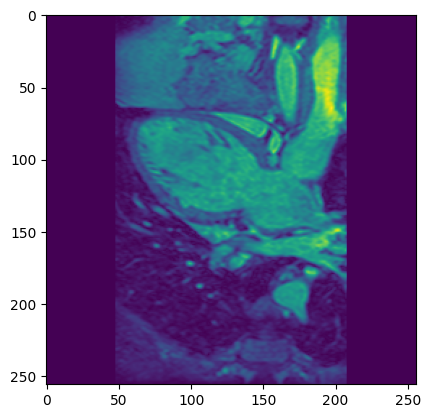

In [70]:
resized_image6 = resized_image6.get_fdata()
show_image = plt.imshow(resized_image6[int(resized_image6.shape[0]/2),:,:])


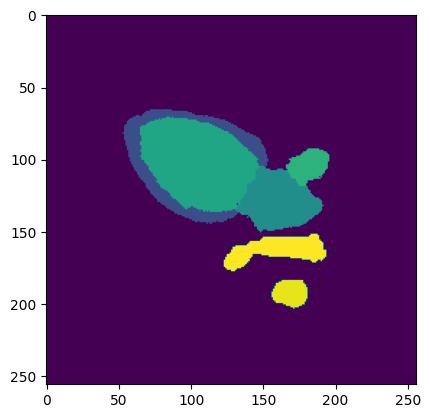

In [73]:
resized_label6 = resized_label6.get_fdata()
show_image = plt.imshow(resized_label6[int(resized_label6.shape[0]/2),:,:])

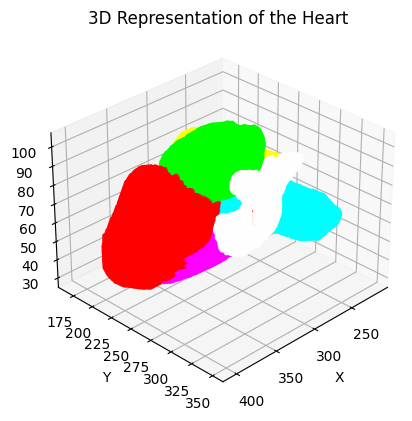

In [32]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

image_path = 'C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/labels/mr_train_1001_label.nii'
image = nib.load(image_path)
image_data = image.get_fdata()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
indices = np.nonzero(image_data)

class_values = [0, 205, 420, 500, 550, 600, 820, 850]
class_colors = ['#000000', '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFFFFF']
cmap = cm.colors.ListedColormap(class_colors)
labels = image_data[indices]
colors = cmap(np.searchsorted(class_values, labels))

ax.scatter(*indices, c=colors, marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Representation of the Heart')
ax.view_init(elev=30, azim=45)
plt.show()


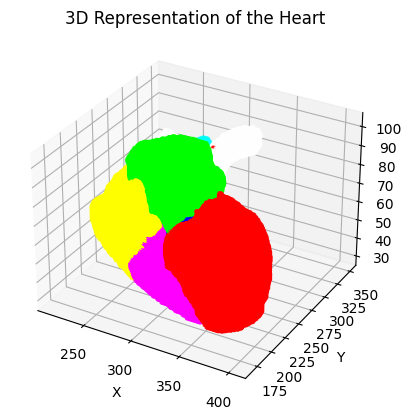

In [33]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

image_path = 'C:/Users/dante/OneDrive/Desktop/3D_Unet_HeartSegmentation/3D_Unet_HeartSegmentation/mr_train/labels/mr_train_1001_label.nii'
image = nib.load(image_path)
image_data = image.get_fdata()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
indices = np.nonzero(image_data)

class_values = [0, 205, 420, 500, 550, 600, 820, 850]
class_colors = ['#000000', '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#FFFFFF']
cmap = cm.colors.ListedColormap(class_colors)

labels = image_data[indices]
colors = cmap(np.searchsorted(class_values, labels))
ax.scatter(*indices, c=colors, marker='.')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Representation of the Heart')
plt.show()
